### Case-Study: Hierarchical clustering (agglomerative) on Vehicle dataset

About: An automobile manufacturer has developed prototypes for a new vehicle. Before introducing the new model into its range, the manufacturer wants to determine which existing vehicles on the market are most like the prototypes - that is, how vehicles can be grouped, which group is the most similar with the model, and therefore which models they will be competing against.

Firstly, we import the libraries as needed

In [30]:
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

We'll use clustering methods, to find the most distinctive clusters of vehicles, and it will summarize the existing vehicles - Here is my goal: We're able to help manufacture make decision about new models simply through the analysis. 

#### Reading data
let's read dataset to see what features the manufacturer has collected about the existing models.

In [2]:
filename = 'cars_clus.csv'
pdf = pd.read_csv(filename)
pdf.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


In [3]:
pdf.columns

Index(['manufact', 'model', 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales', 'partition'],
      dtype='object')

The featuresets include  price in thousands (price), engine size (engine_s), horsepower (horsepow), wheelbase (wheelbas), width (width), length (length), curb weight (curb_wgt), fuel capacity (fuel_cap) and fuel efficiency (mpg).

In [4]:
pdf.describe()

,partition
count,159.000000
mean,0.012579
std,0.111799
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 16 columns):
manufact     157 non-null object
model        159 non-null object
sales        159 non-null object
resale       159 non-null object
type         159 non-null object
price        159 non-null object
engine_s     159 non-null object
horsepow     159 non-null object
wheelbas     159 non-null object
width        159 non-null object
length       159 non-null object
curb_wgt     159 non-null object
fuel_cap     159 non-null object
mpg          159 non-null object
lnsales      159 non-null object
partition    159 non-null float64
dtypes: float64(1), object(15)
memory usage: 20.0+ KB


#### Data transformation & cleaning  

In [6]:
pdf.isnull().sum()

manufact     2
model        0
sales        0
resale       0
type         0
price        0
engine_s     0
horsepow     0
wheelbas     0
width        0
length       0
curb_wgt     0
fuel_cap     0
mpg          0
lnsales      0
partition    0
dtype: int64

In [7]:
pdf.isnull().any()

manufact      True
model        False
sales        False
resale       False
type         False
price        False
engine_s     False
horsepow     False
wheelbas     False
width        False
length       False
curb_wgt     False
fuel_cap     False
mpg          False
lnsales      False
partition    False
dtype: bool

In [31]:
# transformation & cleaning
pdf[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce') ## converting NULL to NaN

# drop NA
df = pdf.dropna()
df = df.reset_index(drop=True)
df.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


In [9]:
## manipulated with another method (table"CTE") 

# pdf = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       #'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       #'mpg', 'lnsales']]
#df = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       #'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       #'mpg', 'lnsales']]

#df = df.apply(pd.to_numeric, errors='coerce')
#df = df.dropna()

In [10]:
df.isnull().any()

manufact     False
model        False
sales        False
resale       False
type         False
price        False
engine_s     False
horsepow     False
wheelbas     False
width        False
length       False
curb_wgt     False
fuel_cap     False
mpg          False
lnsales      False
partition    False
dtype: bool

#### Causal Features selection
Let's select the feature set 

In [32]:
featureset = df[['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]
featureset.head()

,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg
0,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0
1,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0
2,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0
3,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0
4,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0


In [33]:
featureset.values[0:5]

array([[  1.8  , 140.   , 101.2  ,  67.3  , 172.4  ,   2.639,  13.2  ,
         28.   ],
       [  3.2  , 225.   , 108.1  ,  70.3  , 192.9  ,   3.517,  17.2  ,
         25.   ],
       [  3.5  , 210.   , 114.6  ,  71.4  , 196.6  ,   3.85 ,  18.   ,
         22.   ],
       [  1.8  , 150.   , 102.6  ,  68.2  , 178.   ,   2.998,  16.4  ,
         27.   ],
       [  2.8  , 200.   , 108.7  ,  76.1  , 192.   ,   3.561,  18.5  ,
         22.   ]])

#### Normalization
Now we can normalize the feature set. 

__MinMaxScaler__ transforms features by scaling each feature to a given range. It is by default (0, 1). That means this estimator scales and translates each feature individually such that it is between zero and one.

In [34]:
## normalization using MinMaxScaler...

from sklearn.preprocessing import MinMaxScaler
x = featureset.values                    
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.28143713, 0.30625832,
        0.2310559 , 0.13364055, 0.43333333],
       [0.31428571, 0.43037975, 0.3362256 , 0.46107784, 0.5792277 ,
        0.50372671, 0.31797235, 0.33333333],
       [0.35714286, 0.39240506, 0.47722343, 0.52694611, 0.62849534,
        0.60714286, 0.35483871, 0.23333333],
       [0.11428571, 0.24050633, 0.21691974, 0.33532934, 0.38082557,
        0.34254658, 0.28110599, 0.4       ],
       [0.25714286, 0.36708861, 0.34924078, 0.80838323, 0.56724368,
        0.5173913 , 0.37788018, 0.23333333]])

#### Method-1  
We use Scipy package to cluster the dataset:  we first calculate the n x n distance matrix. 

In [35]:
##... clustering....(modeling..)

import scipy
leng = feature_mtx.shape[0]

D = scipy.zeros([leng,leng])      ##... n x n matrix...
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

In [36]:
D[:2,:]

array([[0.        , 0.57777143, 0.75455727, 0.2128736 , 0.77290095,
        1.04388755, 0.36842756, 0.56119503, 0.60285234, 0.7247098 ,
        0.89001868, 0.75843206, 1.02153513, 0.96535724, 0.63567563,
        0.17071078, 0.40323491, 0.61853796, 0.63420586, 0.6754556 ,
        0.93915518, 0.21397175, 0.80969062, 0.37590216, 0.44135804,
        0.789647  , 0.360225  , 0.86544357, 0.43833127, 0.35062872,
        0.41233945, 1.39719208, 1.65751061, 1.36554648, 1.51566212,
        1.07292701, 0.79233821, 0.13903196, 0.54835405, 0.29241045,
        0.6088358 , 1.11985701, 0.7983668 , 1.0894434 , 1.40878766,
        0.66400653, 1.57974136, 0.20393746, 0.3770946 , 0.27656925,
        0.69702407, 1.00353778, 0.26967695, 0.08283378, 0.4222794 ,
        0.5740503 , 0.58142148, 0.57784373, 0.76458229, 0.54793816,
        0.65334392, 0.92651776, 0.98116752, 1.18919833, 0.17306181,
        0.24453155, 0.31160876, 0.62953169, 0.56068485, 0.93464515,
        0.53842915, 0.25073154, 0.29894151, 0.62

Hierarchical clustering does NOT require a pre-specified number of clusters. 

In [37]:
## 

import pylab
import scipy.cluster.hierarchy
Z = hierarchy.linkage(D, 'complete')       

C:\Users\bista\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


In [38]:
Z[:5]

array([[3.60000000e+01, 9.20000000e+01, 5.30569369e-03, 2.00000000e+00],
       [2.80000000e+01, 9.00000000e+01, 1.11182906e-02, 2.00000000e+00],
       [1.12000000e+02, 1.16000000e+02, 1.19477571e-02, 2.00000000e+00],
       [2.10000000e+01, 1.04000000e+02, 2.20380776e-02, 2.00000000e+00],
       [2.60000000e+01, 9.10000000e+01, 5.08875182e-02, 2.00000000e+00]])

A Hierarchical clustering is typically visualized as a dendrogram as shown in the following. Each merge is represented by a horizontal line. The y-coordinate of the horizontal line is the similarity of the two clusters that were merged, where cities are viewed as singleton clusters. 

By moving up from the bottom layer to the top node, a dendrogram allows us to reconstruct the history of merges that resulted in the depicted clustering.

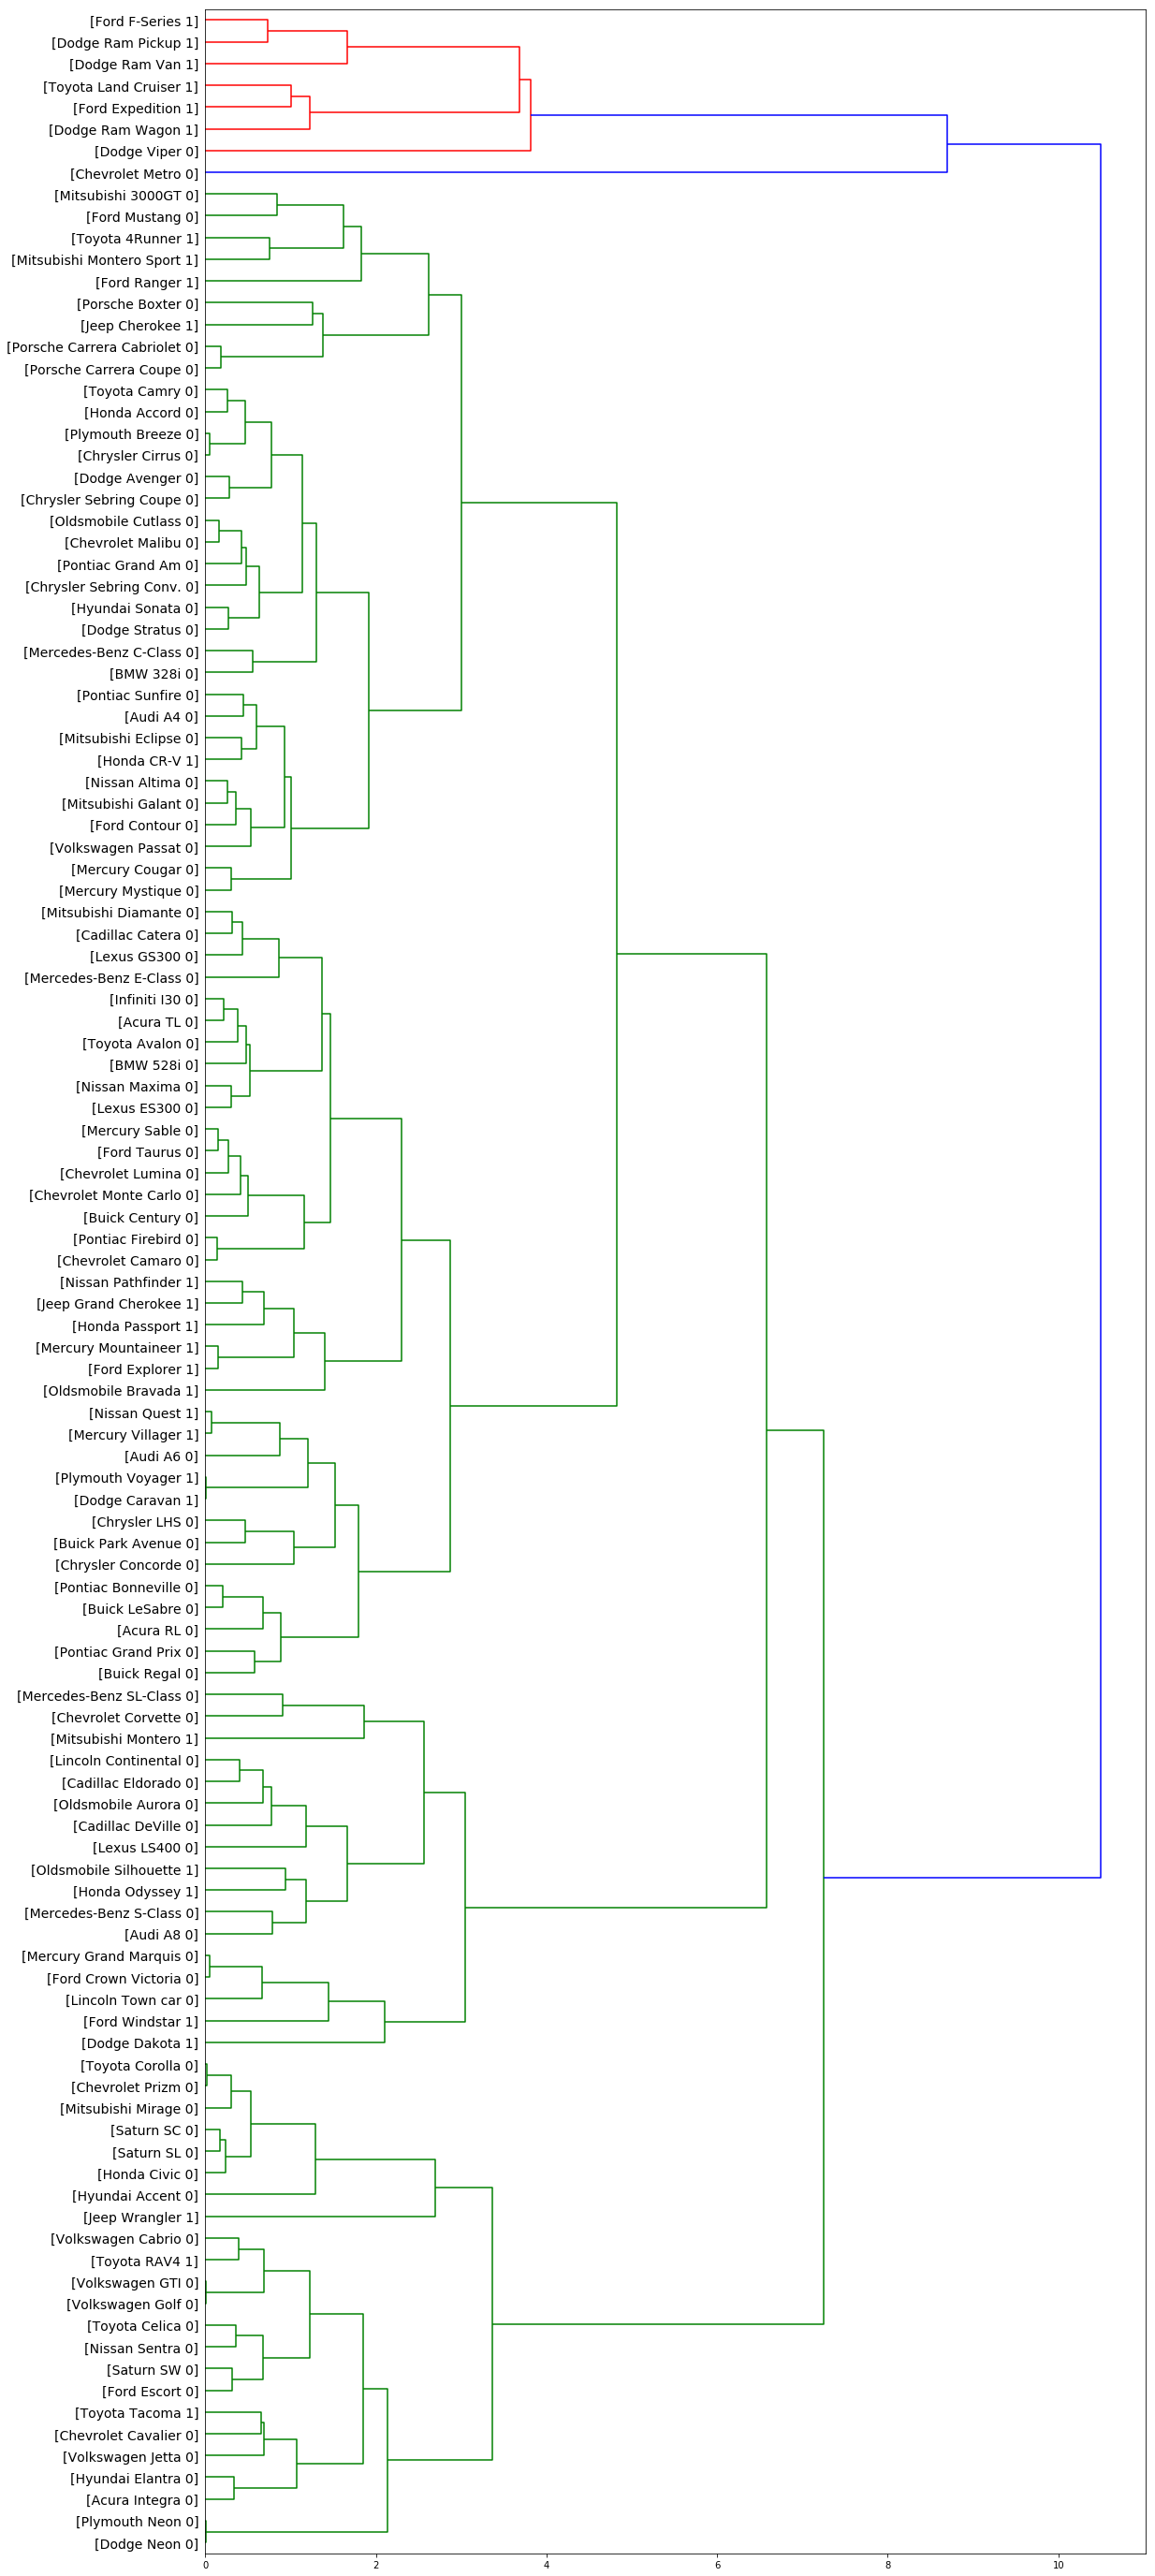

In [39]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (df['manufact'][id], df['model'][id], int(float(df['type'][id])) )
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =14, orientation = 'right')

The linkage methods of Single, Complete, Average, Weighted, Centroid are supported in Scipy for calculating the distance between the newly formed cluster.

Now let's try it on the "Weighted" linkage way. 

C:\Users\bista\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


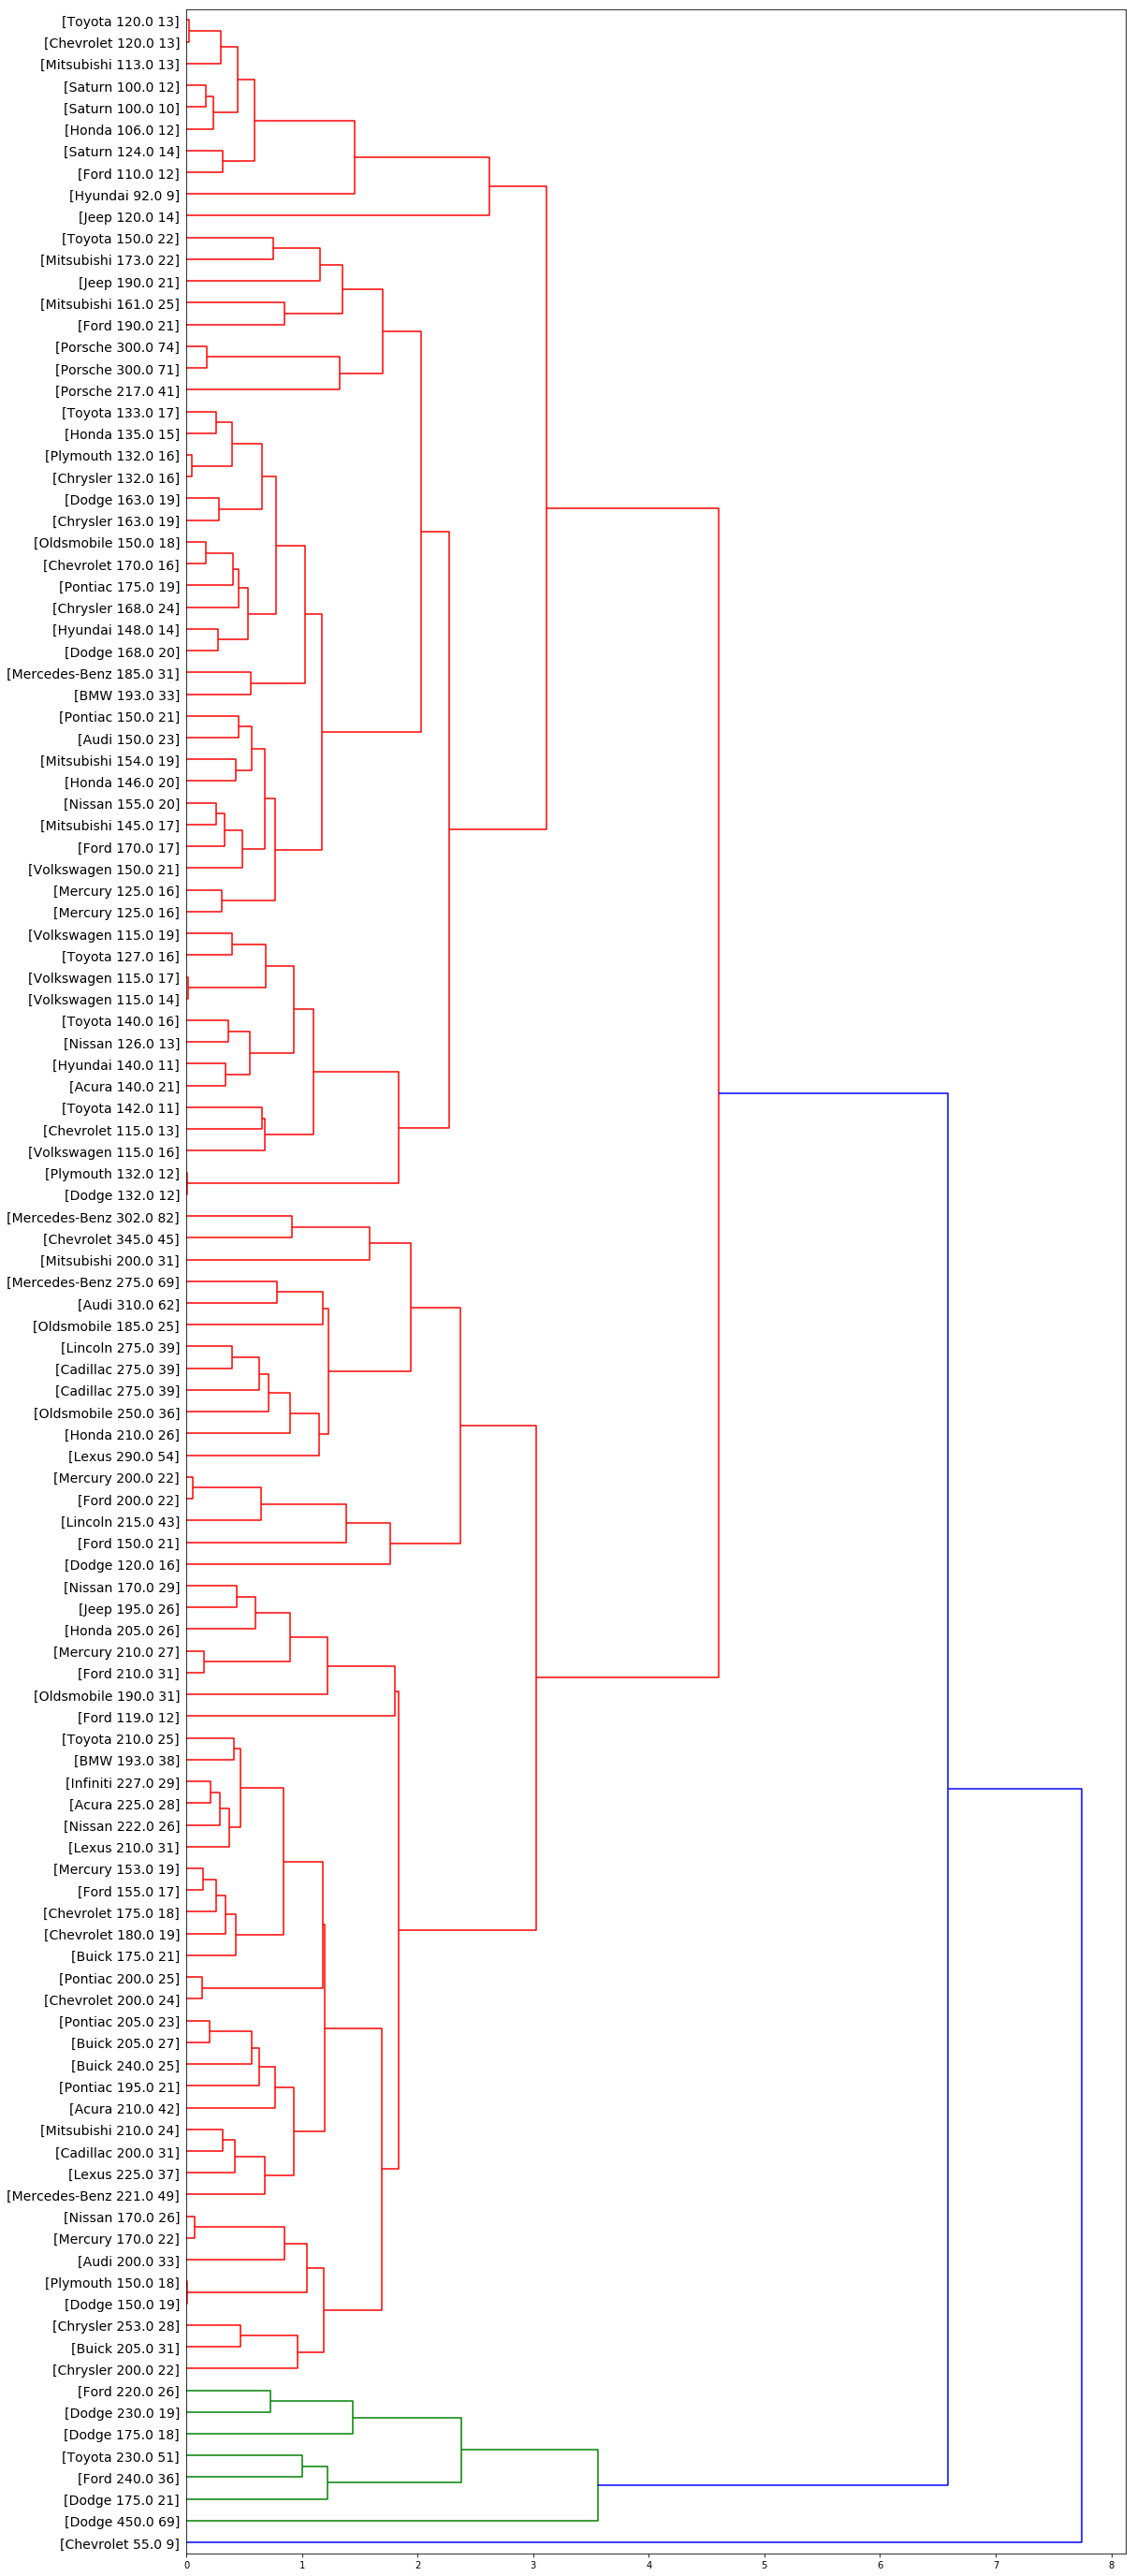

In [19]:
## ...Using scipy-cluster...hierarchy...
# Calculating the distance using "weighted"
import pylab
import scipy.cluster.hierarchy
Z1 = hierarchy.linkage(D, 'weighted') 

# modified the hierarchy2
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (df['manufact'][id], df['horsepow'][id], int(float(df['price'][id])) )
    
dendro = hierarchy.dendrogram(Z1,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =14, orientation = 'right')

Essentially, Hierarchical clustering does NOT require a pre-specified number of clusters. However, in some applications we want a partition of disjoint clusters just as in flat clustering. 

At that point, we can use a cutting line:

In [40]:
# Using a cut-line for a pre-specified number of clusters:
from scipy.cluster.hierarchy import fcluster

max_d = 3     #... set a cut-line....
clusters = fcluster(Z, max_d, criterion='distance')     
clusters

array([ 1,  5,  5,  6,  5,  4,  6,  5,  5,  5,  5,  5,  4,  4,  5,  1,  6,
        5,  5,  5,  4,  2, 11,  6,  6,  5,  6,  5,  1,  6,  6, 10,  9,  8,
        9,  3,  5,  1,  7,  6,  5,  3,  5,  3,  8,  7,  9,  2,  6,  6,  5,
        4,  2,  1,  6,  5,  2,  7,  5,  5,  5,  4,  4,  3,  2,  6,  6,  5,
        7,  4,  7,  6,  6,  5,  3,  5,  5,  6,  5,  4,  4,  1,  6,  5,  5,
        5,  6,  4,  5,  4,  1,  6,  5,  6,  6,  5,  5,  5,  7,  7,  7,  2,
        2,  1,  2,  6,  5,  1,  1,  1,  7,  8,  1,  1,  6,  1,  1],
      dtype=int32)

In [41]:
# also can determine the number of clusters directly:
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters

array([1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 3, 3, 3, 3, 2, 1,
       5, 3, 3, 3, 3, 3, 1, 3, 3, 4, 4, 4, 4, 2, 3, 1, 3, 3, 3, 2, 3, 2,
       4, 3, 4, 1, 3, 3, 3, 2, 1, 1, 3, 3, 1, 3, 3, 3, 3, 2, 2, 2, 1, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 2,
       3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       3, 4, 1, 1, 3, 1, 1], dtype=int32)

#### Method-2: Clustering using Scikit-learn
Let's repeat the data processing from the step of normalization using another method.

In [22]:
# from scipy.spatial import distance_matrix

dist_matrix = distance_matrix(feature_mtx,feature_mtx)   ## n x n matrix D
dist_matrix[:2,:]

array([[0.        , 0.57777143, 0.75455727, 0.2128736 , 0.77290095,
        1.04388755, 0.36842756, 0.56119503, 0.60285234, 0.7247098 ,
        0.89001868, 0.75843206, 1.02153513, 0.96535724, 0.63567563,
        0.17071078, 0.40323491, 0.61853796, 0.63420586, 0.6754556 ,
        0.93915518, 0.21397175, 0.80969062, 0.37590216, 0.44135804,
        0.789647  , 0.360225  , 0.86544357, 0.43833127, 0.35062872,
        0.41233945, 1.39719208, 1.65751061, 1.36554648, 1.51566212,
        1.07292701, 0.79233821, 0.13903196, 0.54835405, 0.29241045,
        0.6088358 , 1.11985701, 0.7983668 , 1.0894434 , 1.40878766,
        0.66400653, 1.57974136, 0.20393746, 0.3770946 , 0.27656925,
        0.69702407, 1.00353778, 0.26967695, 0.08283378, 0.4222794 ,
        0.5740503 , 0.58142148, 0.57784373, 0.76458229, 0.54793816,
        0.65334392, 0.92651776, 0.98116752, 1.18919833, 0.17306181,
        0.24453155, 0.31160876, 0.62953169, 0.56068485, 0.93464515,
        0.53842915, 0.25073154, 0.29894151, 0.62

We can now use the 'AgglomerativeClustering' function from scikit-learn library to cluster the dataset. The AgglomerativeClustering performs a hierarchical clustering using a bottom up approach. The linkage criteria determines the metric used for the merge strategy:

- Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
- Average linkage minimizes the average of the distances between all observations of pairs of clusters.

In [23]:
## Using  'AgglomerativeClustering' function ...pre-set N=6

N=6
agglom = AgglomerativeClustering(n_clusters = N, linkage = 'complete')  ##Single, Complete, Average, Weighted, Centroid    
agglom.fit(feature_mtx)
agglom.labels_

array([1, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 3, 3, 2, 1, 1, 2, 2, 2, 5, 1,
       4, 1, 1, 2, 1, 2, 1, 1, 1, 5, 0, 0, 0, 3, 2, 1, 2, 1, 2, 3, 2, 3,
       0, 3, 0, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2, 3, 3, 3, 1, 1,
       1, 2, 1, 2, 2, 1, 1, 2, 3, 2, 3, 1, 2, 3, 5, 1, 1, 2, 3, 2, 1, 3,
       2, 3, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1], dtype=int64)

And, we can add a new field to our dataframe to show the cluster of each row:

In [24]:
df['cluster_'] = agglom.labels_         
df.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,cluster_
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,1
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,2
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,2
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,1
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,2


In agglomerative clustering, at each iteration, the algorithm (must) updates the distance matrix to reflect the distance of the newly formed cluster with the remaining clusters in the forest. 

Let's plot it before taking MEANS.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Text(0, 0.5, 'mpg')

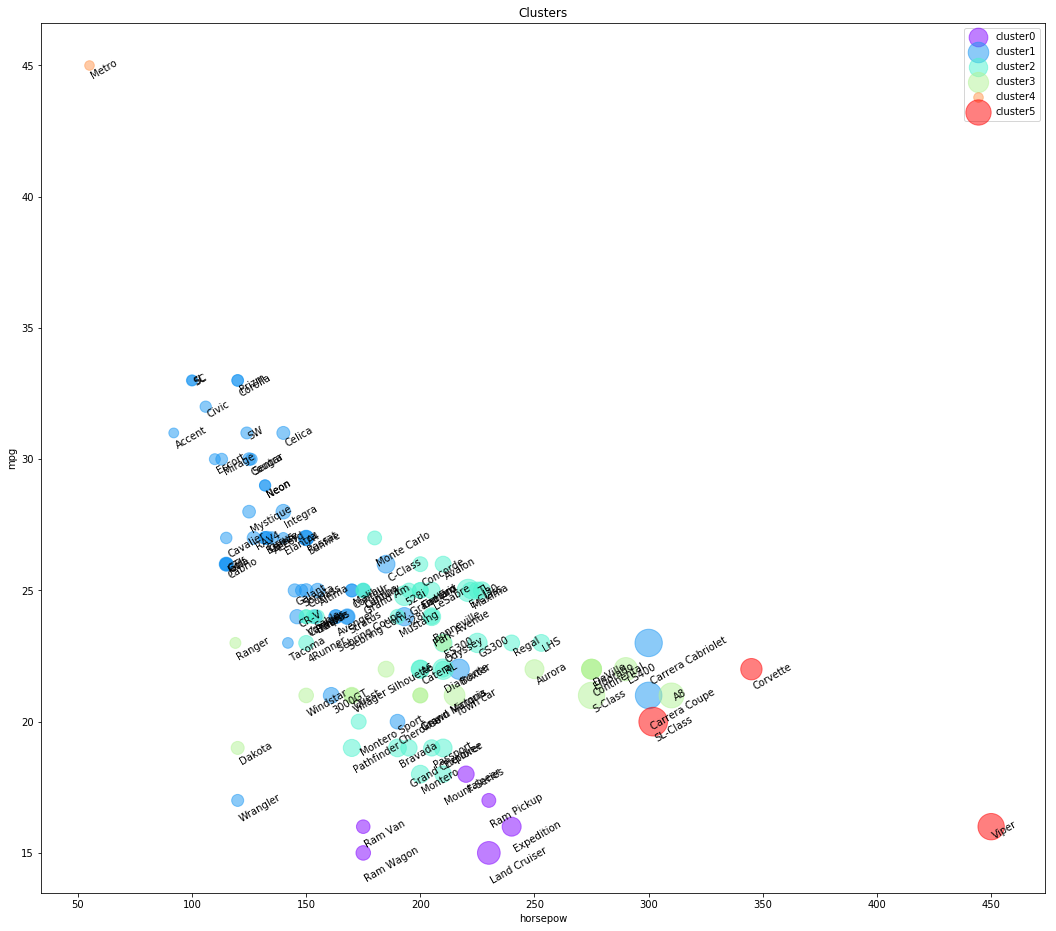

In [25]:
import matplotlib.cm as cm

n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))        # N = 6

# Create a figure of a certain size 
plt.figure(figsize=(18,16))

for color, label in zip(colors, cluster_labels):
    subset = df[df.cluster_ == label]
    for i in subset.index:
            plt.text(subset.horsepow[i], subset.mpg[i],str(subset['model'][i]), rotation=30) 
    plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)

    #    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

We are seeing the distribution of each cluster using the scatter plot, but it is __not very clear__ where is the centroid of each cluster. 

There are 2 types of vehicles in our dataset, "truck" (value of 1 in the type column) and "car" (value of 0 in the type column). Thus, we use them to distinguish the classes, and summarize the cluster. First we count the number of cases in each group:

In [26]:
df.groupby(['cluster_','type'])['cluster_'].count()       

cluster_  type
0         1.0      6
1         0.0     47
          1.0      5
2         0.0     27
          1.0     11
3         0.0     10
          1.0      7
4         0.0      1
5         0.0      3
Name: cluster_, dtype: int64

In [27]:
df.groupby(['cluster_','type'])['type'].count()    

cluster_  type
0         1.0      6
1         0.0     47
          1.0      5
2         0.0     27
          1.0     11
3         0.0     10
          1.0      7
4         0.0      1
5         0.0      3
Name: type, dtype: int64

Now we can look at the characterestics of each cluster (taking MEANs):

In [28]:
agg_cars = df.groupby(['cluster_','type'])['horsepow','engine_s','mpg','price'].mean()
agg_cars

horsepow  engine_s        mpg      price
cluster_ type                                            
0        1.0   211.666667  4.483333  16.166667  29.024667
1        0.0   146.531915  2.246809  27.021277  20.306128
         1.0   145.000000  2.580000  22.200000  17.009200
2        0.0   203.111111  3.303704  24.214815  27.750593
         1.0   182.090909  3.345455  20.181818  26.265364
3        0.0   256.500000  4.410000  21.500000  42.870400
         1.0   160.571429  3.071429  21.428571  21.527714
4        0.0    55.000000  1.000000  45.000000   9.235000
5        0.0   365.666667  6.233333  19.333333  66.010000

Re-plotting it over the means:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Text(0, 0.5, 'mpg')

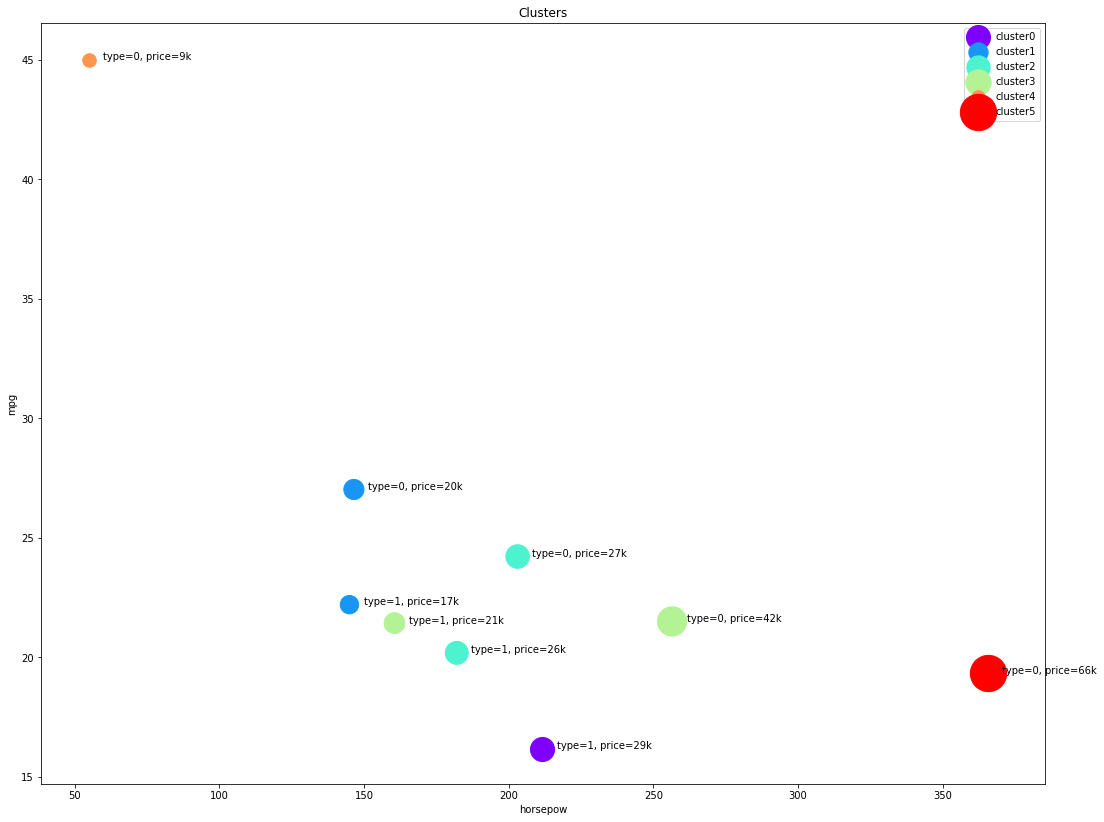

In [29]:
plt.figure(figsize=(18,14))
for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    
    for i in subset.index:
        plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
    plt.scatter(subset.horsepow, subset.mpg, s=subset.price*20, c=color, label='cluster'+str(label))

    plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')


It is obvious that we have 3 main clusters with the majority of vehicles in those.

__Cars__:
- Cluster 1: with almost high mpg, and low in horsepower.
- Cluster 2: with good mpg and horsepower, but higher price than average.
- Cluster 3: with low mpg, high horsepower, highest price.
    
    
    
__Trucks__:
- Cluster 1: with almost highest mpg among trucks, and lowest in horsepower and price.
- Cluster 2: with almost low mpg and medium horsepower, but higher price than average.
- Cluster 3: with good mpg and horsepower, low price.
